# Building The Heisman Dataset
***Sean Steinle***


In this notebook, we'll be pulling together the data we need to answer our questions about the Heisman award.

## Table of Contents

1. [Data Cleaning and Preparation](#1)
    1. [Preparing Votes Data](#1a)
    2. [Setting Up Player and Game APIs](#1b)
    3. [Pulling Stats for Past Heisman Winners](#1c)
2. [Exploratory Data Analysis](#2)
3. [Modeling and Machine Learning](#3)

In [1]:
#import libraries
import cfbd
import pandas as pd
import time

<a id='1'></a><a id='1a'></a>

## Preparing Votes Data

I found the results of the past several decades of Heisman voting here: https://www.sports-reference.com/cfb/awards/heisman.html. In order to import it to this notebook, I created a .csv file by hand.

In [2]:
votes_df = pd.read_csv("../data/heisman_votes.csv")
votes_df = votes_df[votes_df["Year"] > 2003]
votes_df

,Unnamed: 0,Rk,Player,School,Class,Pos,1st,2nd,3rd,Tot,Summary,Year
0,0,1,DeVonta Smith,Alabama,SR,WR,447,221,73,1856,117 Rec 1856 Yds 15.9 Avg 23 TD,2020
1,1,2,Trevor Lawrence,Clemson,JR,QB,222,176,169,1187,231 Cmp 334 Att 3153 Yds 24 TD 5 Int,2020
2,2,3,Mac Jones,Alabama,JR,QB,138,248,220,1130,311 Cmp 402 Att 4500 Yds 41 TD 4 Int,2020
3,3,4,Kyle Trask,Florida,SR,QB,61,164,226,737,301 Cmp 437 Att 4283 Yds 43 TD 8 Int,2020
4,4,5,Najee Harris,Alabama,SR,RB,16,47,74,216,251 Att 1466 Yds 5.8 Avg 26 TD,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
166,166,6,Cedric Benson,Texas,SR,RB,12,41,69,187,326 Att 1834 Yds 5.6 Avg 19 TD,2004
167,167,7,Jason Campbell,Auburn,SR,QB,21,24,51,162,188 Cmp 270 Att 2700 Yds 20 TD 7 Int,2004
168,168,8,J.J. Arrington,California,SR,RB,10,33,19,115,289 Att 2018 Yds 7.0 Avg 15 TD,2004
169,169,9,Aaron Rodgers,California,JR,QB,8,14,15,67,209 Cmp 316 Att 2566 Yds 24 TD 8 Int,2004


In [6]:
players = votes_df['Player']
players

0          DeVonta Smith*\devonta-smith-1
1      Trevor Lawrence*\trevor-lawrence-1
2                  Mac Jones*\mac-jones-1
3                Kyle Trask*\kyle-trask-1
4            Najee Harris*\najee-harris-1
                      ...                
166        Cedric Benson*\cedric-benson-1
167      Jason Campbell*\jason-campbell-1
168        J.J. Arrington*\jj-arrington-1
169        Aaron Rodgers*\aaron-rodgers-1
170    Braylon Edwards*\braylon-edwards-1
Name: Player, Length: 171, dtype: object

In [7]:
#clean names
names = []
for player in players:
    name = player.split('\\')[0]
    if name[-1] == "*": #weird asterisk thing
        names.append(name[:-1])
    else:
        names.append(name)
votes_df["Player"] = names
votes_df["Player"]

0        DeVonta Smith
1      Trevor Lawrence
2            Mac Jones
3           Kyle Trask
4         Najee Harris
            ...       
166      Cedric Benson
167     Jason Campbell
168     J.J. Arrington
169      Aaron Rodgers
170    Braylon Edwards
Name: Player, Length: 171, dtype: object

In [8]:
votes_df.to_csv("heisman_votes.csv")

<a id='1b'></a>

## Setting Up Player and Game APIs

<a id='1bi'></a>

**Configuring Writing Functions**

In [5]:
#API Configuration
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'Jr1LRSHRWqFsEIwxZcp0K/NBQRciKdGb9E+GPLFJHHKdFGkShUyyxdhDlZISY2NB'
configuration.api_key_prefix['Authorization'] = 'Bearer'

players_api = cfbd.PlayersApi(cfbd.ApiClient(configuration))
games_api = cfbd.GamesApi(cfbd.ApiClient(configuration))

In [6]:
#these functions search the players for a 
def pullStatsQB(name, season, team):
    qb = {}
    qb['NAME'] = name
    players = players_api.get_player_season_stats(year=season,team=team)
    for player in players: #more accurately, this would be "for stat in stats"
        if player.player == name:
            if player.category == 'passing': 
                qb["Pass"+player.stat_type] = player.stat
            if player.category == 'rushing':
                qb["Rush"+player.stat_type] = player.stat
    return qb

def pullStatsRB(name, season, team):
    rb = {}
    rb['NAME'] = name
    players = players_api.get_player_season_stats(year=season,team=team)
    for player in players:
        if player.player == name:
            if player.category == 'rushing':
                rb["Rush"+player.stat_type] = player.stat
            if player.category == 'receiving':
                rb["Rec"+player.stat_type] = player.stat
    return rb

def pullStatsWR(name, season, team):
    wr = {}
    wr['NAME'] = name
    players = players_api.get_player_season_stats(year=season,team=team)
    for player in players:
        if player.player == name:
            if player.category == 'rushing':
                wr["Rush"+player.stat_type] = player.stat
            if player.category == 'receiving':
                wr["Rec"+player.stat_type] = player.stat
    return wr

In [7]:
#let's make an additional function to add our heisman stats to these dicts
def addVoteStats(d):
    d['Year'] = row['Year']
    d['School'] = row['School']
    d['Class'] = row['Class']
    d['1stVotes'] = row['1st']
    d['2ndVotes'] = row['2nd']
    d['3rdVotes'] = row['3rd']
    d['TotalVotes'] = row['Tot']
    return d

In [8]:
#let's make one final function that adds the stats of a player's team in
def addTeamStats(d, name, season, team):
    records = games_api.get_team_records(year=season, team=team)
    try:
        d['win_percent'] = records[0].total['wins']/records[0].total['games']
    except:
        d['win_percent'] = -1
    return d

<a id='1bii'></a>

**Testing Functions**

In [9]:
kp = pullStatsQB("Kenny Pickett", 2020, "Pittsburgh")
mi = pullStatsRB("Mark Ingram", 2009, "Alabama")
wr = pullStatsWR("Artavis Scott", 2015, "Clemson")

In [10]:
kp

{'NAME': 'Kenny Pickett',
 'PassYPA': 7.2,
 'PassATT': 333.0,
 'RushYPC': 2.0,
 'RushCAR': 81.0,
 'RushLONG': 18.0,
 'PassCOMPLETIONS': 204.0,
 'RushTD': 8.0,
 'PassPCT': 0.613,
 'PassINT': 9.0,
 'PassYDS': 2408.0,
 'PassTD': 13.0,
 'RushYDS': 162.0}

In [11]:
mi

{'NAME': 'Mark Ingram',
 'RushLONG': 70.0,
 'RecYPR': 10.4,
 'RecTD': 3.0,
 'RecREC': 32.0,
 'RecYDS': 334.0,
 'RecLONG': 69.0,
 'RushCAR': 271.0,
 'RushYPC': 6.1,
 'RushYDS': 1658.0,
 'RushTD': 17.0}

In [12]:
wr

{'NAME': 'Artavis Scott',
 'RushLONG': 10.0,
 'RushYDS': 20.0,
 'RushTD': 1.0,
 'RushCAR': 6.0,
 'RecREC': 93.0,
 'RushYPC': 3.3,
 'RecYDS': 901.0,
 'RecYPR': 9.7,
 'RecTD': 6.0,
 'RecLONG': 51.0}

<a id='1biii'></a>

**Potential Problems**

There were a few cases where the school names from Sports Reference did not align with the CFBD api, in which case I manually changed them (Brigham Young->BYU, Texas Christian->TCU, etc). Additionally, there are a few other cases of key errors I changed manually after exporting the .csv below. Finally, I dropped fumbles as a statistic because of inconsistent access (some players had simple NaN when other sources said they fumbled).

<a id='1c'></a>

## Pulling Stats for Past Heisman Winners

In [ ]:
qbs = []
rbs = []
wrs = []
total_time = time.time()
for i,row in votes_df.iterrows():
    player_time = time.time()
    #gather position specific data
    if row["Pos"] == "QB":
        d = pullStatsQB(row["Player"], row["Year"], row["School"])
        d = addVoteStats(d)
        d = addTeamStats(d, row["Player"], row["Year"], row["School"])
        qbs.append(d)
    elif row["Pos"] == "RB":
        d = pullStatsRB(row["Player"], row["Year"], row["School"])
        d = addVoteStats(d)
        d = addTeamStats(d, row["Player"], row["Year"], row["School"])
        rbs.append(d)
    elif row["Pos"] == "WR":
        d = pullStatsWR(row["Player"], row["Year"], row["School"])
        d = addVoteStats(d)
        d = addTeamStats(d, row["Player"], row["Year"], row["School"])
        wrs.append(d)
    #print("Player processed in: ", time.time()-player_time)

df_qb = pd.DataFrame(qbs)
df_rb = pd.DataFrame(rbs)
df_wr = pd.DataFrame(wrs)
    
print("Finished processing in ", (time.time()-total_time)/60, "mins")

In [ ]:
#df_qb.to_csv("../data/heisman_QBs_copy.csv")
#df_rb.to_csv("../data/heisman_RBs_copy.csv")
#df_wr.to_csv("../data/heisman_WRs_copy.csv")

In [ ]:
df_qb.head(50)

In [ ]:
df_rb

In [ ]:
df_wr

<a id='2'></a>
    
## Exploratory Data Analysis

As I mentioned before, I did some manual correction of a few players, so we'll reload the data and begin to summarize from there.

In [3]:
df_qb = pd.read_csv("../data/heisman_QBs.csv")
df_rb = pd.read_csv("../data/heisman_RBs.csv")
df_wr = pd.read_csv("../data/heisman_WRs.csv")

<a id='2a'></a>

**Extrapositional Factors**

Let's first investigate important factors that do not vary from position to position. Namely, point voting over time, positional bias, team success, year in school, school repuation, and the relationship between first place vote share and total vote share.

*Positional Bias*

In [4]:
#Positional Vote Share
import matplotlib.pyplot as plt

qbrbwr_total = df_qb['TotalVotes'].sum() + df_rb['TotalVotes'].sum() + df_wr['TotalVotes'].sum()
total = votes_df['Tot'].sum()
print("Total number of points since 2004:", total)
print("QB share of points:", round(df_qb['TotalVotes'].sum()/total*100,2),"%")
print("RB share of points:", round(df_rb['TotalVotes'].sum()/total*100,2),"%")
print("WR share of points:", round(df_wr['TotalVotes'].sum()/total*100, 2),"%")
print("Non-QB/RB/WR share of points:", round((1-(qbrbwr_total/total))*100, 2),"%")

Total number of points since 2004: 88890
QB share of points: 66.62 %
RB share of points: 24.5 %
WR share of points: 4.23 %
Non-QB/RB/WR share of points: 4.65 %


Our analysis is operable on over 95% of points in the past 17 years of Heisman voting. Additionally, our analysis is top heavy--all of the past 17 winners have been a QB (13), RB (3), or WR (1).

Additionally, we see that QBs are almost 3x as likely to win the award than RBs, and RBs are about 5x as likely to win than WRs. This should also show up in our model later.

*Voting Over Time*

Text(0.5, 1.0, 'Heisman Votes since 2004')

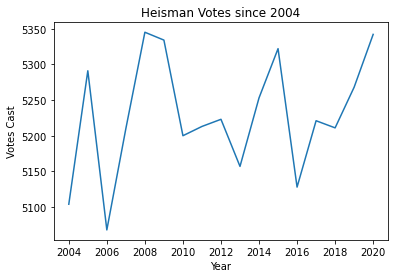

In [5]:
#Votes Diachronically
tot = votes_df.groupby(["Year"]).sum()["Tot"]
plt.plot(tot)
plt.xlabel("Year")
plt.ylabel("Votes Cast")
plt.title("Heisman Votes since 2004")

Worth noting here that even the largest jump saw only a 5% vote increase. The number of votes has been between 5050 and 5350 since 2004. That said, it makes sense to control for percentage of total point total so lets do that now.

In [6]:
firstVotes = votes_df.groupby(["Year"]).sum()["1st"]
year_fvotes_d = firstVotes.to_dict()
year_votes_d = tot.to_dict()

In [7]:
df_qb["TotalPointShare"] = df_qb["TotalVotes"]/df_qb["Year"].map(year_votes_d)
df_qb["1stVoteShare"] = df_qb["1stVotes"]/df_qb["Year"].map(year_fvotes_d)

df_rb["TotalPointShare"] = df_rb["TotalVotes"]/df_rb["Year"].map(year_votes_d)
df_rb["1stVoteShare"] = df_rb["1stVotes"]/df_rb["Year"].map(year_fvotes_d)

df_wr["TotalPointShare"] = df_wr["TotalVotes"]/df_wr["Year"].map(year_votes_d)
df_wr["1stVoteShare"] = df_wr["1stVotes"]/df_wr["Year"].map(year_fvotes_d)

In [8]:
df_qb.sort_values(by="1stVoteShare", ascending=False)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,NAME,PassPCT,PassYPA,PassCOMPLETIONS,PassINT,RushYPC,RushCAR,...,Class,1stVotes,2ndVotes,3rdVotes,TotalVotes,win_percent,VoteShare,PointShare,TotalPointShare,1stVoteShare
78,78,78,6,Joe Burrow,0.763,10.8,402,6,3.2,115,...,SR,841,41,3,2608,1.000000,0.495065,0.495065,0.495065,0.943883
10,10,10,76,Troy Smith,0.653,8.2,203,6,2.8,72,...,SR,801,62,13,2540,0.923077,0.501184,0.501184,0.501184,0.910227
53,53,53,30,Marcus Mariota,0.683,10.0,304,4,5.7,135,...,JR,788,74,22,2534,0.866667,0.482391,0.482391,0.482391,0.885393
29,29,29,53,Cam Newton,0.661,10.2,185,7,5.6,264,...,JR,729,24,28,2263,1.000000,0.435192,0.435192,0.435192,0.825595
68,68,68,17,Baker Mayfield,0.705,11.5,285,6,3.2,97,...,SR,732,87,28,2398,0.857143,0.459299,0.459299,0.459299,0.825254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,63,63,29,Trevone Boykin,0.649,9.0,257,10,5.0,123,...,SR,1,3,4,13,0.846154,0.002443,0.002443,0.002443,0.001117
55,55,55,32,J.T. Barrett,0.646,9.0,203,10,5.5,171,...,FR,0,19,40,78,0.933333,0.014849,0.014849,0.014849,0.000000
34,34,34,58,Colin Kaepernick,0.649,8.4,233,8,7.0,173,...,SR,0,7,17,31,0.928571,0.005962,0.005962,0.005962,0.000000
33,33,33,57,Ryan Mallett,0.647,9.4,266,12,-1.7,44,...,JR,0,11,19,41,0.769231,0.007885,0.007885,0.007885,0.000000


In [9]:
df_rb.sort_values(by="1stVoteShare", ascending=False)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,NAME,RecLONG,RecYDS,RecTD,RecYPR,RushTD,RushYPC,...,Year,School,Class,1stVotes,2ndVotes,3rdVotes,TotalVotes,win_percent,TotalPointShare,1stVoteShare
0,0,0,46,Reggie Bush,43,438,2,13.3,16,9.0,...,2005,USC,JR,784,89,11,2541,0.923077,0.480249,0.878924
1,1,1,18,Derrick Henry,28,91,0,8.3,28,5.6,...,2015,Alabama,JR,378,277,144,1832,0.933333,0.344231,0.422346
2,2,2,39,Darren McFadden,57,164,1,7.8,16,5.6,...,2007,Arkansas,JR,291,355,120,1703,0.615385,0.326871,0.330306
3,3,3,19,Christian McCaffrey,75,645,5,14.3,8,6.0,...,2015,Stanford,SO,290,246,177,1539,0.857143,0.289177,0.324022
4,4,4,34,Mark Ingram,69,334,3,10.4,17,6.1,...,2009,Alabama,SO,227,236,151,1304,1.000000,0.244469,0.252784
6,6,6,35,Toby Gerhart,33,157,0,14.3,27,5.5,...,2009,Stanford,SR,222,225,160,1276,0.615385,0.239220,0.247216
8,8,8,49,Adrian Peterson,6,12,0,2.4,15,5.7,...,2004,Oklahoma,FR,154,180,175,997,0.923077,0.195337,0.178654
9,9,9,29,Trent Richardson,61,338,3,11.7,21,5.9,...,2011,Alabama,JR,138,207,150,978,0.923077,0.187608,0.156463
12,12,12,50,Reggie Bush,69,509,7,11.8,6,6.3,...,2004,USC,SO,118,80,83,597,1.000000,0.116967,0.136891
5,5,5,9,Bryce Love,12,33,0,5.5,19,8.1,...,2017,Stanford,JR,75,421,233,1300,0.642857,0.248994,0.084555


In [10]:
df_wr.sort_values(by="1stVoteShare", ascending=False)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,NAME,RecYPR,RushTD,RecLONG,RecYDS,RushYDS,RushCAR,...,Year,School,Class,1stVotes,2ndVotes,3rdVotes,TotalVotes,win_percent,TotalPointShare,1stVoteShare
0,0,0,0,DeVonta Smith,15.9,1,66,1856,6,4,...,2020,Alabama,SR,447,221,73,1856,1.000000,0.347435,0.495017
1,1,1,2,Amari Cooper,13.9,0,80,1727,23,5,...,2014,Alabama,JR,49,280,316,1023,0.857143,0.194746,0.055056
3,3,3,3,Marqise Lee,14.6,0,83,1721,106,13,...,2012,USC,SO,19,33,84,207,0.538462,0.039632,0.021300
2,2,2,1,Dede Westbrook,19.1,0,88,1524,101,10,...,2016,Oklahoma,SR,7,49,90,209,0.846154,0.040757,0.007937
7,7,7,4,Tavon Austin,11.3,3,75,1289,643,72,...,2012,West Virginia,SR,6,4,21,47,0.538462,0.008999,0.006726
6,6,6,11,Braylon Edwards,13.7,0,69,1330,61,6,...,2004,Michigan,SR,3,13,27,62,0.750000,0.012147,0.003480
4,4,4,8,Michael Crabtree,12.0,0,82,1165,1,2,...,2008,Texas Tech,SO,3,27,53,116,0.846154,0.021703,0.003326
10,10,10,6,Mardy Gilyard,13.7,1,68,1191,16,5,...,2009,Cincinnati,SR,2,2,13,23,0.923077,0.004312,0.002227
11,11,11,7,Golden Tate,16.1,2,78,1496,186,25,...,2009,Notre Dame,JR,2,3,9,21,0.500000,0.003937,0.002227
8,8,8,9,Dwayne Jarrett,14.5,0,62,1015,-3,1,...,2006,USC,JR,1,11,22,47,0.846154,0.009274,0.001136


In [11]:
#save to csvs
df_qb.to_csv("../data/heisman_QBs.csv")
df_rb.to_csv("../data/heisman_RBs.csv")
df_wr.to_csv("../data/heisman_WRs.csv")

Now we have a much more standardized way of predicting Heisman winners--proportion of 1st place vote. This is a much better measure than a total point count because it is focused on getting first place votes and it is also scaled to each year's vote total.

*Year in School*

In [12]:
qb_votes_by_class = df_qb.groupby("Class").sum()["TotalVotes"]
qb_fvotes_by_class = df_qb.groupby("Class").sum()["1stVotes"]
print("QBs\n")
print("Total Points:\n",qb_votes_by_class.sort_values(ascending=False)/df_qb["TotalVotes"].sum())
print("\nFirst Place Votes\n",qb_fvotes_by_class.sort_values(ascending=False)/df_qb["1stVotes"].sum())

rb_votes_by_class = df_rb.groupby("Class").sum()["TotalVotes"]
rb_fvotes_by_class = df_rb.groupby("Class").sum()["1stVotes"]
print("\n\nRBs")
print("Total Points:\n",rb_votes_by_class.sort_values(ascending=False)/df_rb["TotalVotes"].sum())
print("\nFirst Place Votes\n",rb_fvotes_by_class.sort_values(ascending=False)/df_rb["1stVotes"].sum())

wr_votes_by_class = df_wr.groupby("Class").sum()["TotalVotes"]
wr_fvotes_by_class = df_wr.groupby("Class").sum()["1stVotes"]
print("\nWRs")
print("Total Points:\n",wr_votes_by_class.sort_values(ascending=False)/df_wr["TotalVotes"].sum())
print("\nFirst Place Votes\n",wr_fvotes_by_class.sort_values(ascending=False)/df_wr["1stVotes"].sum())


QBs

Total Points:
 Class
JR    0.406194
SR    0.307626
SO    0.213364
FR    0.072816
Name: TotalVotes, dtype: float64

First Place Votes
 Class
JR    0.410839
SR    0.307763
SO    0.176858
FR    0.104540
Name: 1stVotes, dtype: float64


RBs
Total Points:
 Class
JR    0.550009
SO    0.271078
SR    0.130465
FR    0.048448
Name: TotalVotes, dtype: float64

First Place Votes
 Class
JR    0.599278
SO    0.240564
SR    0.108960
FR    0.051198
Name: 1stVotes, dtype: float64

WRs
Total Points:
 Class
SR    0.584464
JR    0.301676
SO    0.113860
Name: TotalVotes, dtype: float64

First Place Votes
 Class
SR    0.859519
JR    0.097967
SO    0.042514
Name: 1stVotes, dtype: float64


This checks out logically. You can leave for the draft after your sophomore year, so exceptionally talented players have their best college year as a sophomore. Most players take at least one more year, maybe two. One thing to consider here is that there is no consideration for redshirting.

*School Factor*

In [28]:
qb_votes_by_school = df_qb.groupby("School").sum()["TotalVotes"]/df_qb["TotalVotes"].sum()
qb_fvotes_by_school = df_qb.groupby("School").sum()["1stVotes"]/df_qb["1stVotes"].sum()
print("QBs\n")
print("Total Points:\n",qb_votes_by_school.sort_values(ascending=False))
print("\nFirst Place Votes\n",qb_fvotes_by_school.sort_values(ascending=False))

rb_votes_by_school = df_rb.groupby("School").sum()["TotalVotes"]/df_rb["TotalVotes"].sum()
rb_fvotes_by_school = df_rb.groupby("School").sum()["1stVotes"]/df_rb["1stVotes"].sum()
print("\n\nRBs")
print("Total Points:\n",rb_votes_by_school.sort_values(ascending=False))
print("\nFirst Place Votes\n",rb_fvotes_by_school.sort_values(ascending=False))

wr_votes_by_school = df_wr.groupby("School").sum()["TotalVotes"]/df_wr["TotalVotes"].sum()
wr_fvotes_by_school = df_wr.groupby("School").sum()["1stVotes"]/df_wr["1stVotes"].sum()
print("\nWRs")
print("Total Points:\n",wr_votes_by_school.sort_values(ascending=False))
print("\nFirst Place Votes\n",wr_fvotes_by_school.sort_values(ascending=False))


QBs

Total Points:
 School
Oklahoma             0.146999
Florida              0.078675
Ohio State           0.074825
Texas                0.073576
Clemson              0.066939
Alabama              0.062971
Louisville           0.049596
Oregon               0.045797
LSU                  0.044041
Stanford             0.041980
Texas A&M            0.041373
Auburn               0.040950
USC                  0.038417
Florida State        0.038097
Baylor               0.030852
Notre Dame           0.017073
Kansas State         0.015097
Hawaii               0.014084
Boise State          0.013932
Utah                 0.010723
Northern Illinois    0.010301
Missouri             0.007177
West Virginia        0.004982
TCU                  0.004407
Texas Tech           0.003597
Washington           0.003073
Navy                 0.003040
Houston              0.002702
Washington State     0.002060
Fresno State         0.001807
UCF                  0.001570
Michigan             0.001418
California   

0.9534053460270964

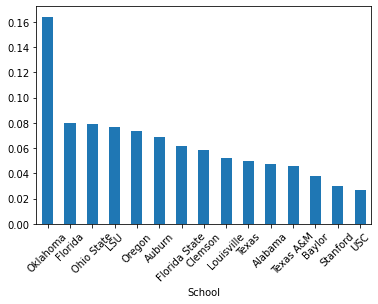

In [59]:
qb_fvotes_by_school.sort_values(ascending=False)[:15].plot.bar(rot=45)
qb_fvotes_by_school.sort_values(ascending=False)[:15].sum()

0.902855267476206

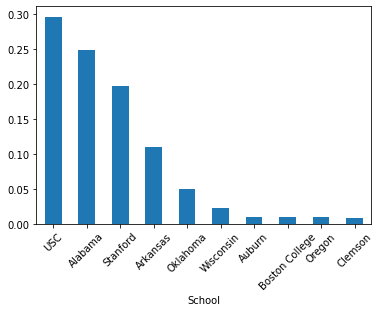

In [55]:
rb_fvotes_by_school.sort_values(ascending=False)[:10].plot.bar(rot=45)
rb_fvotes_by_school.sort_values(ascending=False)[:5].sum()

<AxesSubplot:xlabel='School'>

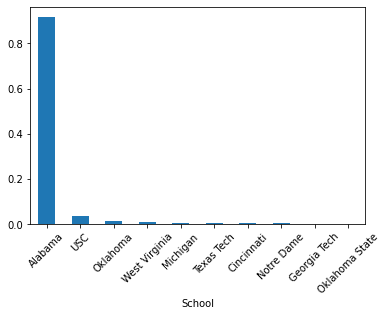

In [32]:
wr_fvotes_by_school.sort_values(ascending=False)[:10].plot.bar(rot=45)

Interestingly, Heisman votes are very concentrated by school across all three positions. For QBs, only 15 schools represent 95% of the first place votes and 87% of all points in the past 17 years. For RBs, only 5 schools are needed to represent 90% of first place votes. For WRs, Alabama represents well over 80% of first place votes. It makes sense that only a few schools have dominated the RB and WR positions in the Heisman race because there are so few RB and WR candidates.

*Team Success*

In [86]:
print(df_qb["1stVoteShare"].corr(df_qb["win_percent"]))
print(df_rb["1stVoteShare"].corr(df_rb["win_percent"]))
print(df_wr["1stVoteShare"].corr(df_wr["win_percent"])) #This is because Alabama was undefeated during Smith's Heisman campaign.

0.16108030694694714
0.19354693104712548
0.45855776022820083


<AxesSubplot:>

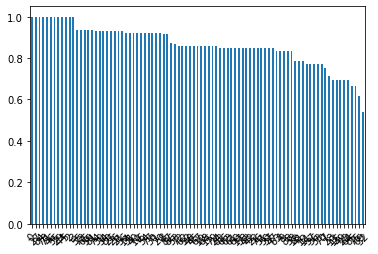

In [69]:
df_qb["win_percent"].sort_values(ascending=False).plot.bar(rot=45)

<AxesSubplot:>

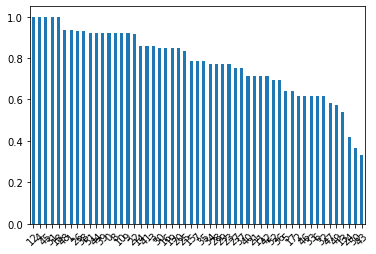

In [76]:
df_rb["win_percent"].sort_values(ascending=False).plot.bar(rot=45)

In [73]:
df_qb.sort_values(by="win_percent",ascending=False).tail(10)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,NAME,PassPCT,PassYPA,PassCOMPLETIONS,PassINT,RushYPC,RushCAR,...,Class,1stVotes,2ndVotes,3rdVotes,TotalVotes,win_percent,VoteShare,PointShare,TotalPointShare,1stVoteShare
28,28,28,63,Case Keenum,0.703,8.1,492,15,2.6,60,...,JR,2,9,13,37,0.714286,0.006937,0.006937,0.006937,0.002227
13,13,13,70,Tim Tebow,0.669,9.4,234,6,4.3,210,...,SO,462,229,113,1957,0.692308,0.375624,0.375624,0.375624,0.524404
16,16,16,73,Dennis Dixon,0.677,8.4,172,4,5.6,105,...,SR,17,31,65,178,0.692308,0.034165,0.034165,0.034165,0.019296
49,49,49,39,Johnny Manziel,0.699,9.6,300,13,5.3,144,...,SO,30,103,125,421,0.692308,0.081637,0.081637,0.081637,0.033595
23,23,23,68,Pat White,0.657,6.7,180,7,5.1,191,...,SR,3,1,8,19,0.692308,0.003555,0.003555,0.003555,0.003326
64,64,64,21,Lamar Jackson,0.562,8.7,230,9,6.0,260,...,SO,526,251,64,2144,0.692308,0.418097,0.418097,0.418097,0.596372
85,85,85,2,Kyle Trask,0.689,9.8,301,8,0.8,64,...,SR,61,164,226,737,0.666667,0.137963,0.137963,0.137963,0.067553
75,75,75,14,Will Grier,0.670,9.7,266,8,-1.9,49,...,SR,4,17,80,126,0.666667,0.024180,0.024180,0.024180,0.004556
69,69,69,18,Lamar Jackson,0.591,8.5,254,10,6.9,232,...,JR,47,197,258,793,0.615385,0.151887,0.151887,0.151887,0.052988
32,32,32,56,Denard Robinson,0.625,8.8,182,11,6.6,256,...,SO,6,16,34,84,0.538462,0.016154,0.016154,0.016154,0.006795


In [79]:
df_rb.sort_values(by="win_percent",ascending=False).tail(20)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,NAME,RecLONG,RecYDS,RecTD,RecYPR,RushTD,RushYPC,...,Year,School,Class,1stVotes,2ndVotes,3rdVotes,TotalVotes,win_percent,TotalPointShare,1stVoteShare
37,37,37,1,Breece Hall,28,180,2,7.8,21,5.6,...,2020,Iowa State,SO,6,10,26,64,0.750000,0.011981,0.006645
40,40,40,40,Kevin Smith,42,242,1,10.1,29,5.7,...,2007,UCF,JR,3,11,24,55,0.714286,0.010557,0.003405
21,21,21,2,Jonathan Taylor,36,252,5,9.7,21,6.3,...,2019,Wisconsin,JR,6,44,83,189,0.714286,0.035877,0.006734
11,11,11,41,Darren McFadden,70,148,1,13.5,14,5.8,...,2006,Arkansas,SO,45,298,147,878,0.714286,0.173244,0.051136
42,42,42,13,Kerryon Johnson,55,194,2,8.1,18,4.9,...,2017,Auburn,JR,0,14,17,45,0.714286,0.008619,0.000000
52,52,52,38,Javon Ringer,17,190,0,6.8,22,4.2,...,2008,Michigan State,SR,1,0,5,8,0.692308,0.001497,0.001109
36,36,36,37,Shonn Greene,23,49,0,6.1,20,6.0,...,2008,Iowa,JR,5,9,32,65,0.692308,0.012161,0.005543
5,5,5,9,Bryce Love,12,33,0,5.5,19,8.1,...,2017,Stanford,JR,75,421,233,1300,0.642857,0.248994,0.084555
17,17,17,36,C.J. Spiller,63,503,4,14.0,12,5.6,...,2009,Clemson,SR,26,31,83,223,0.642857,0.041807,0.028953
2,2,2,39,Darren McFadden,57,164,1,7.8,16,5.6,...,2007,Arkansas,JR,291,355,120,1703,0.615385,0.326871,0.330306


Text(0, 0.5, 'Share of 1st Place Votes')

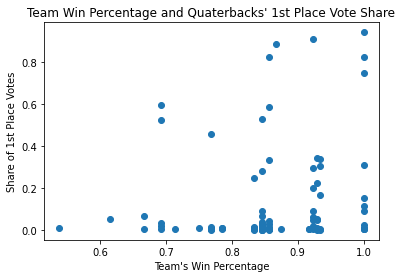

In [99]:
scatter = plt.scatter(df_qb["win_percent"], df_qb["1stVoteShare"])
plt.title("Team Win Percentage and Quaterbacks' 1st Place Vote Share")
plt.xlabel("Team's Win Percentage")
plt.ylabel("Share of 1st Place Votes")

Although the correlation is low between winning percentage and 1st vote share, it looks like being on a winning team may be acting as a barrier to winning.

*1st Place Votes and Total Points*

Text(0, 0.5, '1st Place Vote Share')

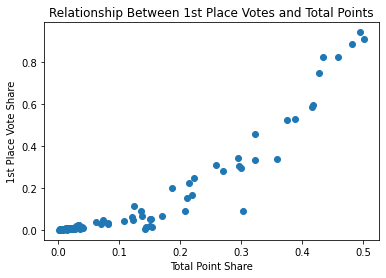

In [105]:
scatter = plt.scatter(df_qb["TotalPointShare"], df_qb["1stVoteShare"])
plt.title("Relationship Between 1st Place Votes and Total Points")
plt.xlabel("Total Point Share")
plt.ylabel("1st Place Vote Share")

Interestingly, this scatter plot (as well as the RB/WR versions) takes a concave shape. This is likely because there tends to be a concentration of players who do not get many first place votes but still get a lot of total points from 2nd and 3rd place votes. This concentration may be increased by unified Heisman races, where there are clear winners and runner-ups.

<a id='2b'></a>

**QB Factors**

In [14]:
df_qb.columns
df_qb["1stVoteShare"].corr(df_qb["PassYDS"])

0.17564681674438598

<a id='2c'></a>

**RB Factors**

In [ ]:
corr matrices

<a id='2d'></a>

**WR Factors**

<a id='3'></a>
## Modeling and Machine Learning

In [ ]:
clustering

models